In [14]:
#import necessary packages
import pandas as pd
from datetime import datetime, timedelta, timezone
import os
from PyEIS import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import csv
import glob
import statistics
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
import math
from colour import Color
import re
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.ticker import AutoMinorLocator

from matplotlib.pyplot import rc

allSized=20
rc('text',usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']},size=allSized)
rc('text.latex', preamble=r'\usepackage{sfmath}')
plt.rc('font',   size=     allSized,**{'family':"sans-serif"})     # controls default text sizes
plt.rc('axes',   titlesize=allSized)     # fontsize of the axes title
plt.rc('axes',   labelsize=allSized)    # fontsize of the x and y labels
plt.rc('xtick',  labelsize=allSized)    # fontsize of the tick labels
plt.rc('ytick',  labelsize=allSized)    # fontsize of the tick labels
plt.rc('legend', fontsize= allSized)    # legend fontsize
plt.rc('figure', titlesize=allSized)  # fontsize of the figure title

In [15]:
# Function to calculate Euclidean distance between two points
def calculate_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2 + (coord1[2] - coord2[2])**2)


def cartesian_to_spherical(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r) if r != 0 else 0  # θ: angle from z-axis
    phi = np.arctan2(y, x)  # φ: angle from x-axis in the xy-plane
    return r, np.degrees(theta), np.degrees(phi)


In [16]:
start_file="C:/Users/austi/OneDrive - Colorado School of Mines/Research/Beamline Data/CLS_12_2023/Python Processed Str/Consolidated strs/3by3/Li6PS5Cl_P1_dualLi_limited rotation_beqpdfgui_site disorder_Lioccref.txt"

end_file="C:/Users/austi/OneDrive - Colorado School of Mines/Research/Beamline Data/CLS_12_2023/Joint Refinements/PDF SA_ Joint Refinement working copy/SSM LPSC/6_28_2024_LPSC_SSM/6_28_2024_Cl_SSM_3by3_100k_Joint_Lorchdamping_Lioccref.inp"

material=r'SSM Li$_6$PS$_5$Cl'

datacolor='#3d64ff'

lattice_param=29.555673

#filter non-alphanumeric and space characters from the material name so that it's easier to deal with from a file management perspective
cleaned_matname = filter(lambda x: x.isalnum() or x.isspace(), material)

# filter returns a generator, so we need to re-join the string
cleaned_matname = "".join(cleaned_matname)

print(cleaned_matname)

saveloc='C:/Users/austi/OneDrive - Colorado School of Mines/Research/Beamline Data/CLS_12_2023/Joint Refinements/Paper Plotting/PS4 Rotations and cifs/rotation plots'

SSM Li6PS5Cl


In [17]:
start_coordinates={}

# Regular expression pattern to match the lines with start_coordinates
pattern = re.compile(r"site\s+(P\d+|S\d{2,})\s+num_posns\s+\d+\s+x\s+([\d.-]+)\s+y\s+([\d.-]+)\s+z\s+([\d.-]+)")

# Open the file and process each line
with open(start_file) as file:
    for line in file:
        match = pattern.search(line)
        if match:
            site = match.group(1)
            x = float(match.group(2))
            y = float(match.group(3))
            z = float(match.group(4))
            
            # Determine whether the site is P or S
            if site.startswith('P'):
                unit_number = int(site[1:])
                if unit_number not in start_coordinates:
                    start_coordinates[unit_number] = {'P': None, 'S': {}}
                start_coordinates[unit_number]['P'] = (x, y, z)
            elif site.startswith('S'):
                unit_number = int(site[1:-1])
                sulfur_number = int(site[-1])
                if unit_number not in start_coordinates:
                    start_coordinates[unit_number] = {'P': None, 'S': {}}
                start_coordinates[unit_number]['S'][sulfur_number] = (x, y, z)

# Example: Accessing the start_coordinates for a specific thiophosphate unit
example_unit = 1
print(f"start_coordinates for P{example_unit}: {start_coordinates[example_unit]['P']}")
for i in range(1, 5):
    print(f"start_coordinates for S{example_unit}{i}: {start_coordinates[example_unit]['S'][i]}")

start_coordinates for P1: (0.25, 0.25, 0.083333)
start_coordinates for S11: (0.29, 0.21, 0.12333)
start_coordinates for S12: (0.21, 0.29, 0.12333)
start_coordinates for S13: (0.29, 0.29, 0.04333)
start_coordinates for S14: (0.21, 0.21, 0.04333)


In [18]:
# Initialize the dictionary to store the end_coordinates
end_coordinates = {}

# Regular expression pattern to match the lines with end_coordinates, accounting for '_0.00000' or any number
pattern = re.compile(
    r"site\s+(P\d+|S\d{2,})\s+num_posns\s+\d+\s+x\s+([\d.]+)(?:`_|\s*[_])\s*[\d.]+\s+y\s+([\d.]+)(?:`_|\s*[_])\s*[\d.]+\s+z\s+([\d.]+)(?:`_|\s*[_])\s*[\d.]+"
)
# Open the file and process each line
with open(end_file) as file:
    for line in file:
        match = pattern.search(line)
        if match:
            site = match.group(1)
            x = float(match.group(2))
            y = float(match.group(3))
            z = float(match.group(4))
            
            # Determine whether the site is P or S
            if site.startswith('P'):
                unit_number = int(site[1:])
                if unit_number not in end_coordinates:
                    end_coordinates[unit_number] = {'P': None, 'S': {}}
                end_coordinates[unit_number]['P'] = (x, y, z)
            elif site.startswith('S'):
                unit_number = int(site[1:-1])
                sulfur_number = int(site[-1])
                if unit_number not in end_coordinates:
                    end_coordinates[unit_number] = {'P': None, 'S': {}}
                end_coordinates[unit_number]['S'][sulfur_number] = (x, y, z)


# Example: Accessing the end_coordinates for a specific thiophosphate unit
example_unit = 50
print(f"end_coordinates for P{example_unit}: {end_coordinates[example_unit]['P']}")
for i in range(1, 5):
    print(f"end_coordinates for S{example_unit}{i}: {end_coordinates[example_unit]['S'][i]}")

end_coordinates for P50: (0.75, 0.58333, 0.58333)
end_coordinates for S501: (0.79325, 0.54538, 0.62147)
end_coordinates for S502: (0.70756, 0.6186, 0.62486)
end_coordinates for S503: (0.78622, 0.62754, 0.5446)
end_coordinates for S504: (0.71297, 0.54186, 0.5424)


In [19]:
# Dictionary to store closest sulfur pairs
closest_sulfur_pairs = {}

# Find the closest sulfur atom for each S1 from start to end units
for unit_number, start_sulfurs in start_coordinates.items():
    if 'S' in start_sulfurs:
        start_sulfur1_coords = start_sulfurs['S'].get(1)
        if start_sulfur1_coords:
            min_distance = float('inf')
            closest_sulfur = None
            for sulfur_number, end_sulfur_coords in end_coordinates[unit_number]['S'].items():
                distance = calculate_distance(start_sulfur1_coords, end_sulfur_coords)
                if distance < min_distance:
                    min_distance = distance
                    closest_sulfur = sulfur_number
            closest_sulfur_pairs[unit_number] = {
                'start_sulfur': start_sulfur1_coords,
                'closest_end_sulfur': closest_sulfur,
                'end_sulfur_coords': end_coordinates[unit_number]['S'][closest_sulfur],
                'distance': min_distance
            }

# Example: Print out the closest sulfur atom pairs
for unit, data in closest_sulfur_pairs.items():
    print(f"Unit {unit}:")
    print(f"  Start S{unit}1 Coordinates: {data['start_sulfur']}")
    print(f"  Closest End S{unit}{data['closest_end_sulfur']} Coordinates: {data['end_sulfur_coords']}")
    print(f"  Distance: {data['distance']:.5f}")

Unit 1:
  Start S11 Coordinates: (0.29, 0.21, 0.12333)
  Closest End S12 Coordinates: (0.29074, 0.21607, 0.12763)
  Distance: 0.00748
Unit 2:
  Start S21 Coordinates: (0.29, 0.29, 0.37667)
  Closest End S24 Coordinates: (0.29104, 0.29099, 0.37913)
  Distance: 0.00285
Unit 3:
  Start S31 Coordinates: (0.29, 0.29, 0.71)
  Closest End S33 Coordinates: (0.29186, 0.28795, 0.71023)
  Distance: 0.00278
Unit 4:
  Start S41 Coordinates: (0.21, 0.62333, 0.12333)
  Closest End S44 Coordinates: (0.20201, 0.61537, 0.12132)
  Distance: 0.01146
Unit 5:
  Start S51 Coordinates: (0.29, 0.62333, 0.37667)
  Closest End S54 Coordinates: (0.28263, 0.63365, 0.3823)
  Distance: 0.01388
Unit 6:
  Start S61 Coordinates: (0.29, 0.62333, 0.71)
  Closest End S64 Coordinates: (0.288, 0.63105, 0.71755)
  Distance: 0.01098
Unit 7:
  Start S71 Coordinates: (0.29, 0.87667, 0.12333)
  Closest End S71 Coordinates: (0.29126, 0.86758, 0.10913)
  Distance: 0.01691
Unit 8:
  Start S81 Coordinates: (0.21, 0.87667, 0.37667)
 

In [20]:
# Dictionary to store rotation information
rotation_data = {}

# Calculate theta and phi for each thiophosphate unit
for unit, data in closest_sulfur_pairs.items():
    # Vector from P to starting S1
    start_p_coords = start_coordinates[unit]['P']
    start_s_coords = data['start_sulfur']
    start_vector = np.array([start_s_coords[0] - start_p_coords[0], 
                             start_s_coords[1] - start_p_coords[1], 
                             start_s_coords[2] - start_p_coords[2]])
    
    # Vector from P to ending Sx
    end_p_coords=end_coordinates[unit]['P']
    end_s_coords = data['end_sulfur_coords']
    end_vector = np.array([end_s_coords[0] - end_p_coords[0], 
                           end_s_coords[1] - end_p_coords[1], 
                           end_s_coords[2] - end_p_coords[2]])
    
    # Convert vectors to spherical coordinates
    start_r, start_theta, start_phi = cartesian_to_spherical(*start_vector)
    end_r, end_theta, end_phi = cartesian_to_spherical(*end_vector)
    
    # Store the rotation data
    rotation_data[unit] = {
        'start_theta': start_theta, 'start_phi': start_phi,  # Reference (0, 0)
        'end_theta': end_theta, 
        'end_phi': end_phi,
        'rotation_theta': end_theta-start_theta,  # Since start_theta is 0
        'rotation_phi': end_phi-start_phi  # Since start_phi is 0
    }

# Example: Print the rotational data for each thiophosphate unit
for unit, data in rotation_data.items():
    print(f"Unit {unit}:")
    print(f"  Start θ: {data['start_theta']}°, Start φ: {data['start_phi']}°")
    print(f"  End θ: {data['end_theta']}°, End φ: {data['end_phi']}°")
    print(f"  Rotation θ: {data['rotation_theta']}°, Rotation φ: {data['rotation_phi']}°")

Unit 1:
  Start θ: 54.737636079599916°, Start φ: -45.00000000000002°
  End θ: 50.11946299624163°, End φ: -39.788967229942735°
  Rotation θ: -4.618173083358286°, Rotation φ: 5.211032770057287°
Unit 2:
  Start θ: 125.2623639204001°, Start φ: 45.0°
  End θ: 122.91082174051822°, End φ: 44.965076330356354°
  Rotation θ: -2.351542179881889°, Rotation φ: -0.03492366964364635°
Unit 3:
  Start θ: 125.26438968275468°, Start φ: 45.0°
  End θ: 125.14058118755699°, End φ: 42.19524466913673°
  Rotation θ: -0.12380849519769299°, Rotation φ: -2.804755330863273°
Unit 4:
  Start θ: 54.73662324273851°, Start φ: 135.00214867230594°
  End θ: 56.640103054280985°, End φ: 146.27137728093643°
  Rotation θ: 1.903479811542475°, Rotation φ: 11.269228608630499°
Unit 5:
  Start θ: 125.26337675726151°, Start φ: 44.997851327694114°
  End θ: 119.8164422524945°, End φ: 57.03861112825163°
  Rotation θ: -5.446934504767015°, Rotation φ: 12.040759800557517°
Unit 6:
  Start θ: 125.26540254493958°, Start φ: 44.99785132769411

In [21]:
df = pd.DataFrame({
    r'PS$_4$$^{3-}$ unit': list(rotation_data.keys()),
    r'$\theta$ ($^\circ$)': [data['rotation_theta'] for data in rotation_data.values()],
    r'$\phi$ ($^\circ$)': [data['rotation_phi'] for data in rotation_data.values()],
    r'Displacement of S (\AA)': [data['distance']*lattice_param for data in closest_sulfur_pairs.values()]
})

display(df)

readytosave=True
if readytosave==True:
    if not os.path.isdir(saveloc):
        os.makedirs(saveloc)
    df.to_csv(f"{saveloc}/{cleaned_matname} displacements.csv")

,PS$_4$$^{3-}$ unit,$\theta$ ($^\circ$),$\phi$ ($^\circ$),Displacement of S (\AA)
0,1,-4.618173,5.211033,0.220942
1,2,-2.351542,-0.034924,0.084186
2,3,-0.123808,-2.804755,0.082094
3,4,1.903480,11.269229,0.338592
4,5,-5.446935,12.040760,0.410086
...,...,...,...,...
103,104,-0.806174,-3.062943,0.094394
104,105,12.749816,-6.525913,0.497145
105,106,-3.899485,2.972260,0.162779
106,107,-7.112911,-4.711749,0.291210


In [22]:
import numpy as np

# Initialize sums for theta, phi rotations, and distance
total_theta_rotation = 0
total_phi_rotation = 0
total_distance = 0

# Initialize sums for squared differences
sum_squared_diff_theta = 0
sum_squared_diff_phi = 0
sum_squared_diff_distance = 0

# Count the number of units
num_units = len(rotation_data)

# Collect all theta, phi, and distance values
theta_values = []
phi_values = []
distance_values = []

# Sum up the rotations and collect values for all units
for unit, data in rotation_data.items():
    total_theta_rotation += data['rotation_theta']
    total_phi_rotation += data['rotation_phi']
    theta_values.append(data['rotation_theta'])
    phi_values.append(data['rotation_phi'])

for unit, data in closest_sulfur_pairs.items():
    total_distance += data['distance']
    distance_values.append(data['distance'])

# Calculate the average theta, phi rotations, and distance
average_theta_rotation = total_theta_rotation / num_units
average_phi_rotation = total_phi_rotation / num_units
average_distance = total_distance / num_units

# Calculate the squared differences from the mean for each unit
for unit, data in rotation_data.items():
    sum_squared_diff_theta += (data['rotation_theta'] - average_theta_rotation) ** 2
    sum_squared_diff_phi += (data['rotation_phi'] - average_phi_rotation) ** 2

for unit, data in closest_sulfur_pairs.items():
    sum_squared_diff_distance += (data['distance'] - average_distance) ** 2

# Calculate the variances using `num_units - 1` for the denominator
variance_theta = sum_squared_diff_theta / (num_units - 1)
variance_phi = sum_squared_diff_phi / (num_units - 1)
variance_distance = sum_squared_diff_distance / (num_units - 1)

# Calculate the standard deviations
std_dev_theta = variance_theta ** 0.5
std_dev_phi = variance_phi ** 0.5
std_dev_distance = variance_distance ** 0.5

# Convert average distance and standard deviation to angstroms
average_distance_angstrom = average_distance * lattice_param
std_dev_distance_angstrom = std_dev_distance * lattice_param

# Calculate the medians for theta, phi, and distance
median_theta_rotation = np.median(theta_values)
median_phi_rotation = np.median(phi_values)
median_distance = np.median(distance_values)
median_distance_angstrom = median_distance * lattice_param

# Print the average, median rotations, and their standard deviations
print(f"Average θ rotation: {average_theta_rotation}°, Standard Deviation: {std_dev_theta}°")
print(f"Median θ rotation: {median_theta_rotation}°")
print(f"Average φ rotation: {average_phi_rotation}°, Standard Deviation: {std_dev_phi}°")
print(f"Median φ rotation: {median_phi_rotation}°")
print(f"Average Displacement: {average_distance_angstrom} angstroms, Standard Deviation: {std_dev_distance_angstrom} angstroms")
print(f"Median Displacement: {median_distance_angstrom} angstroms")


Average θ rotation: 0.35186050898350585°, Standard Deviation: 10.720192863455052°
Median θ rotation: 0.7696327663658913°
Average φ rotation: 2.6625935548384736°, Standard Deviation: 11.425710879189786°
Median φ rotation: 0.5468886157900457°
Average Displacement: 0.3399505818427026 angstroms, Standard Deviation: 0.311545176755197 angstroms
Median Displacement: 0.2529999616110287 angstroms


In [23]:
#generate a table for average displacements

attributes=[r'$\theta$ ($^\circ$)', r'$\phi$ ($^\circ$)', r'Displacement of S (\AA)']
averages=[average_theta_rotation, average_phi_rotation,average_distance_angstrom]
medians=[median_theta_rotation,median_phi_rotation,median_distance_angstrom]
std_devs=[std_dev_theta,std_dev_phi,std_dev_distance_angstrom]

collated={
    r'Attribute':attributes,
    r'Average':averages,
    r'Median':medians,
    r'Standard Deviation':std_devs,
}

collated=pd.DataFrame(collated)

display(collated)

readytosave=False
if readytosave==True:
    if not os.path.isdir(saveloc):
        os.makedirs(saveloc)
    collated.to_csv(f"{saveloc}/{cleaned_matname} dispersities.csv")

,Attribute,Average,Median,Standard Deviation
0,$\theta$ ($^\circ$),0.351861,0.769633,10.720193
1,$\phi$ ($^\circ$),2.662594,0.546889,11.425711
2,Displacement of S (\AA),0.339951,0.253000,0.311545


In [24]:
# Initialize variables to store the maximum distance and the corresponding unit
max_distance = 0
max_unit = None
max_sulfur_pair = None

# Iterate through the closest_sulfur_pairs dictionary
for unit, data in closest_sulfur_pairs.items():
    # Extract the distance value
    distance = data['distance']
    
    # Check if this is the maximum distance encountered so far
    if distance > max_distance:
        max_distance = distance
        max_unit = unit
        max_sulfur_pair = (data['start_sulfur'], data['closest_end_sulfur'])

# Print the results
print(f"Maximum distance: {max_distance}")
print(f"Unit number: {max_unit}")
print(f"Starting sulfur: {max_sulfur_pair[0]}")
print(f"Ending sulfur: {max_sulfur_pair[1]}")
print(f"Maximum θ:{rotation_data[max_unit]['rotation_theta']}°")
print(f"Maximum φ:{rotation_data[max_unit]['rotation_phi']}°")

Maximum distance: 0.06358711819228799
Unit number: 67
Starting sulfur: (0.62333, 0.37667, 0.29)
Ending sulfur: 1
Maximum θ:-54.73358450424422°
Maximum φ:44.999999999999964°


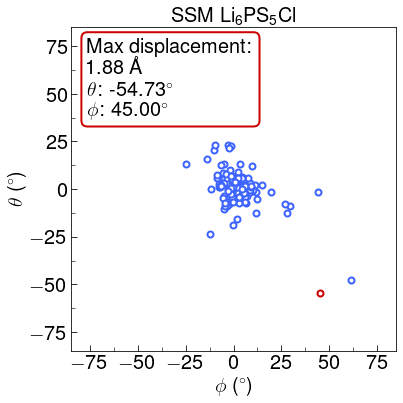

In [25]:
readytosave=True

fig, axs=plt.subplots(1,1, figsize=(6,6))

max_theta = rotation_data[max_unit]['rotation_theta']
max_phi = rotation_data[max_unit]['rotation_phi']

if abs(max_phi)>abs(max_theta):
    lim=abs(max_phi)*1.05
else:
    lim=abs(max_theta)*1.05
    
lim=85


for unit, data in rotation_data.items():
    if unit!=max_unit:
        axs.scatter(data['rotation_phi'],data['rotation_theta'],edgecolor=datacolor,facecolors='white',linewidths=2, marker='o')
    else:
        axs.scatter(rotation_data[max_unit]['rotation_phi'],rotation_data[max_unit]['rotation_theta'], edgecolor='#cc0000',facecolors='white',linewidths=2, marker='o')
#axs.scatter(0,0,color="orange",edgecolor='black',marker='^',s=150)

axs.text(-lim+lim*0.1,lim*.45,fr'Max displacement:' '\n' fr'{max_distance*lattice_param:.2f} \AA' '\n' fr'$\theta$: {max_theta:.2f}$^\circ$' '\n' fr'$\phi$: {max_phi:.2f}$^\circ$',bbox=dict(
        facecolor='none',     # Transparent fill color for the box
       edgecolor="#cc0000",  # Match the box edge color with the marker
        linewidth=2,        # Box edge width
       boxstyle='round,pad=0.3'  # Rounded box with padding
  ))
    
axs.set_xlim([-lim,lim])
axs.set_ylim([-lim,lim])

axs.xaxis.set_major_locator(ticker.MaxNLocator(8))
axs.yaxis.set_major_locator(ticker.MaxNLocator(8))
axs.xaxis.set_minor_locator(AutoMinorLocator(2))
axs.yaxis.set_minor_locator(AutoMinorLocator(2))
plt.tick_params(which='major', direction='in', length=6)
plt.tick_params(which='minor', direction='in', length=4)

axs.set_xlabel(r'$\phi$ ($^{\circ}$)')
axs.set_ylabel(r'$\theta$ ($^{\circ}$)')
axs.set_title(material)

plt.tight_layout()

if readytosave==True:
    png=''.join((saveloc,'/',cleaned_matname,'rotation summary','.png'))
    if not os.path.isdir(saveloc):
        os.makedirs(saveloc)
    plt.savefig(png,dpi=800,format='png')


plt.show()